In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colab에서 한글 폰트 깨짐 현상 해결 위함
# 돌리고 런타임 다시 시작해야함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') # 한글 폰트 설정
import missingno as mino
import seaborn as sns
import datetime
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
dirpath = '/content/drive/MyDrive/flood/'
df = pd.read_excel(dirpath+'dataset.xlsx', header=[0,1])
col = [_[0] for _ in df.columns[:6]]
df.columns = np.append(col, df.columns[6:].map('_'.join))
df.columns = [_.replace('데이터 집단', '데이터집단') for _ in df.columns]
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),데이터집단 1_강우(D지역),데이터집단 1_수위(E지역),데이터집단 1_수위(D지역),데이터집단 2_유역평균강수,데이터집단 2_강우(A지역),데이터집단 2_강우(B지역),데이터집단 2_강우(C지역),데이터집단 2_강우(D지역),데이터집단 2_수위(E지역),데이터집단 2_수위(D지역),데이터집단 3_유역평균강수,데이터집단 3_강우(A지역),데이터집단 3_강우(B지역),데이터집단 3_강우(C지역),데이터집단 3_강우(D지역),데이터집단 3_수위(E지역),데이터집단 3_수위(D지역),데이터집단 4_유역평균강수,데이터집단 4_강우(A지역),데이터집단 4_강우(B지역),데이터집단 4_강우(C지역),데이터집단 4_강우(D지역),데이터집단 4_수위(E지역),데이터집단 4_수위(D지역),데이터집단 5_유역평균강수,데이터집단 5_강우(A지역),데이터집단 5_강우(B지역),데이터집단 5_강우(C지역),데이터집단 5_강우(D지역),데이터집단 5_수위(E지역),데이터집단 5_수위(D지역),데이터집단 6_유역평균강수,데이터집단 6_강우(A지역),데이터집단 6_강우(B지역),데이터집단 6_강우(C지역),데이터집단 6_강우(D지역),데이터집단 6_수위(E지역),데이터집단 6_수위(D지역)
0,1,2006,7,10,8,189.100000,6.4,7,7,7,8,2.54,122.56875,6.3,7,7,7,8,2.54,122.541667,6.3,7,7,7,8,2.54,122.550000,6.4,7,7,8,8,2.54,122.675000,6.4,7,7,8,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,8,2.53,122.56250,6.4,7,8,7,8,2.53,122.550000,6.4,7,8,7,8,2.53,122.558333,7.3,7,8,10,10,2.53,122.667857,7.3,7,8,10,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,8,2.53,122.55625,7.3,7,9,7,8,2.53,122.558333,7.3,7,9,8,8,2.53,122.566667,8.2,7,9,10,11,2.53,122.660714,8.2,7,9,10,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,8,2.53,122.55625,8.2,7,10,8,8,2.53,122.566667,8.2,7,10,10,10,2.53,122.575000,11.3,9,10,15,14,2.53,122.653571,11.3,9,10,15,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,10,2.53,122.55625,11.3,9,12,10,10,2.53,122.575000,11.3,9,12,10,11,2.53,122.575000,14.4,12,12,18,16,2.53,122.639286,14.4,12,12,18,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [4]:
df.shape

(3051, 48)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   홍수사상번호           3051 non-null   int64  
 1   연                3051 non-null   int64  
 2   월                3051 non-null   int64  
 3   일                3051 non-null   int64  
 4   시간               3051 non-null   int64  
 5   유입량              2891 non-null   float64
 6   데이터집단 1_유역평균강수   3051 non-null   float64
 7   데이터집단 1_강우(A지역)  3051 non-null   int64  
 8   데이터집단 1_강우(B지역)  3051 non-null   int64  
 9   데이터집단 1_강우(C지역)  3051 non-null   int64  
 10  데이터집단 1_강우(D지역)  3051 non-null   int64  
 11  데이터집단 1_수위(E지역)  3051 non-null   float64
 12  데이터집단 1_수위(D지역)  3051 non-null   float64
 13  데이터집단 2_유역평균강수   3051 non-null   float64
 14  데이터집단 2_강우(A지역)  3051 non-null   int64  
 15  데이터집단 2_강우(B지역)  3051 non-null   int64  
 16  데이터집단 2_강우(C지역)  3051 non-null   int64  
 17  데이터집단 2_강우(D지역

In [6]:
df.describe()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),데이터집단 1_강우(D지역),데이터집단 1_수위(E지역),데이터집단 1_수위(D지역),데이터집단 2_유역평균강수,데이터집단 2_강우(A지역),데이터집단 2_강우(B지역),데이터집단 2_강우(C지역),데이터집단 2_강우(D지역),데이터집단 2_수위(E지역),데이터집단 2_수위(D지역),데이터집단 3_유역평균강수,데이터집단 3_강우(A지역),데이터집단 3_강우(B지역),데이터집단 3_강우(C지역),데이터집단 3_강우(D지역),데이터집단 3_수위(E지역),데이터집단 3_수위(D지역),데이터집단 4_유역평균강수,데이터집단 4_강우(A지역),데이터집단 4_강우(B지역),데이터집단 4_강우(C지역),데이터집단 4_강우(D지역),데이터집단 4_수위(E지역),데이터집단 4_수위(D지역),데이터집단 5_유역평균강수,데이터집단 5_강우(A지역),데이터집단 5_강우(B지역),데이터집단 5_강우(C지역),데이터집단 5_강우(D지역),데이터집단 5_수위(E지역),데이터집단 5_수위(D지역),데이터집단 6_유역평균강수,데이터집단 6_강우(A지역),데이터집단 6_강우(B지역),데이터집단 6_강우(C지역),데이터집단 6_강우(D지역),데이터집단 6_수위(E지역),데이터집단 6_수위(D지역)
count,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,2891.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000,3051.000000
mean,14.936742,2011.145198,7.404130,15.106850,12.538184,1746.902717,67.938486,78.058669,64.361849,39.822353,53.558178,4.564936,131.539823,68.420307,81.216978,63.484104,39.237955,53.558178,4.564936,131.611259,68.420307,81.216978,57.197640,39.462144,53.958047,4.564936,131.648782,68.894845,82.796132,57.197640,51.313668,55.723697,4.564936,131.378003,67.093879,82.796132,57.197640,51.313668,55.723697,4.564936,131.424801,61.540773,82.796132,58.112422,38.908882,53.596198,4.564936,131.471568
std,7.575733,3.097788,0.689192,7.850888,6.936676,2181.790290,59.359959,71.874728,63.369565,46.097700,56.327987,2.375226,6.061602,59.315391,72.927209,62.906248,45.493394,56.327987,2.375226,6.060190,59.315391,72.927209,59.607926,45.461439,56.342398,2.375226,6.056126,59.261035,73.434296,59.607926,52.312274,56.848675,2.375226,6.051400,58.399205,73.434296,59.607926,52.312274,56.848675,2.375226,6.054328,55.735872,73.434296,60.093366,44.747886,55.649384,2.375226,6.060749
min,1.000000,2006.000000,6.000000,1.000000,1.000000,3.541153,0.000000,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000,0.017700,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000,0.017700,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000,0.017700,0.000000,0.000000,0.000000,0.000000,1.070000,118.700000
25%,10.000000,2009.000000,7.000000,10.000000,7.000000,384.762514,20.500000,22.000000,13.000000,3.000000,7.000000,2.810000,127.331250,20.917250,23.000000,13.000000,3.000000,7.000000,2.810000,127.333333,20.917250,23.000000,9.000000,3.000000,7.000000,2.810000,127.341667,21.100000,23.000000,9.000000,8.000000,9.000000,2.810000,127.275000,20.431100,23.000000,9.000000,8.000000,9.000000,2.810000,127.296000,16.002550,23.000000,10.000000,3.000000,7.000000,2.810000,127.317500
50%,16.000000,2011.000000,7.000000,15.000000,13.000000,1065.549253,57.198300,55.000000,52.000000,22.000000,35.000000,4.080000,133.012500,58.500000,57.000000,52.000000,21.000000,35.000000,4.080000,133.050000,58.500000,57.000000,44.000000,22.000000,37.000000,4.080000,133.058333,59.100000,59.000000,44.000000,33.000000,38.000000,4.080000,133.035714,56.117700,59.000000,44.000000,33.000000,38.000000,4.080000,133.028000,47.411600,59.000000,46.000000,22.000000,37.000000,4.080000,133.010000
75%,22.000000,2013.000000,8.000000,20.000000,19.000000,2213.014288,103.226400,121.000000,91.000000,65.000000,85.000000,5.580000,135.175000,103.413650,123.000000,90.000000,64.000000,85.000000,5.580000,135.200000,103.413650,123.000000,84.000000,64.000000,85.000000,5.580000,135.200000,103.424300,127.000000,84.000000,79.000000,86.000000,5.580000,135.110714,101.150000,

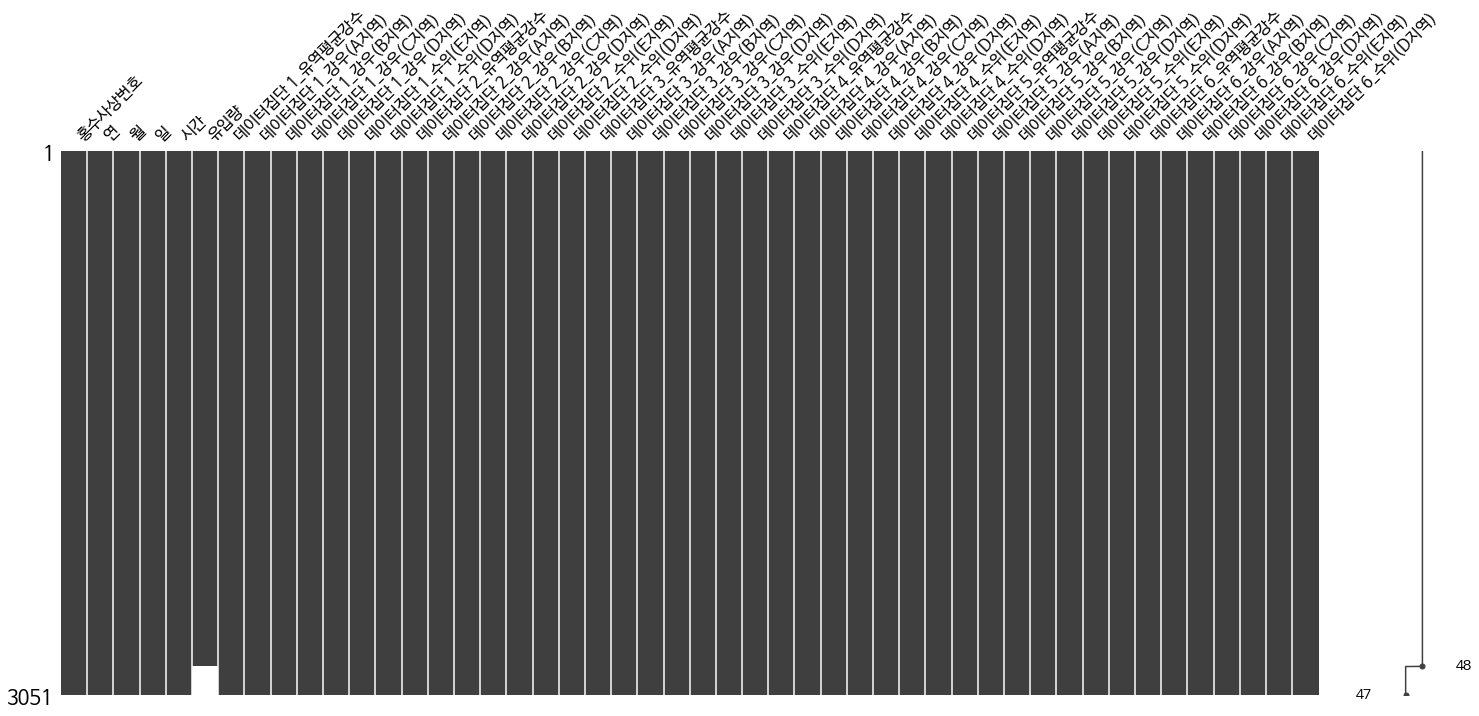

In [7]:
mino.matrix(df)

test set 부분의 유입량(종속변수)을 제외하고 결측치가 없음

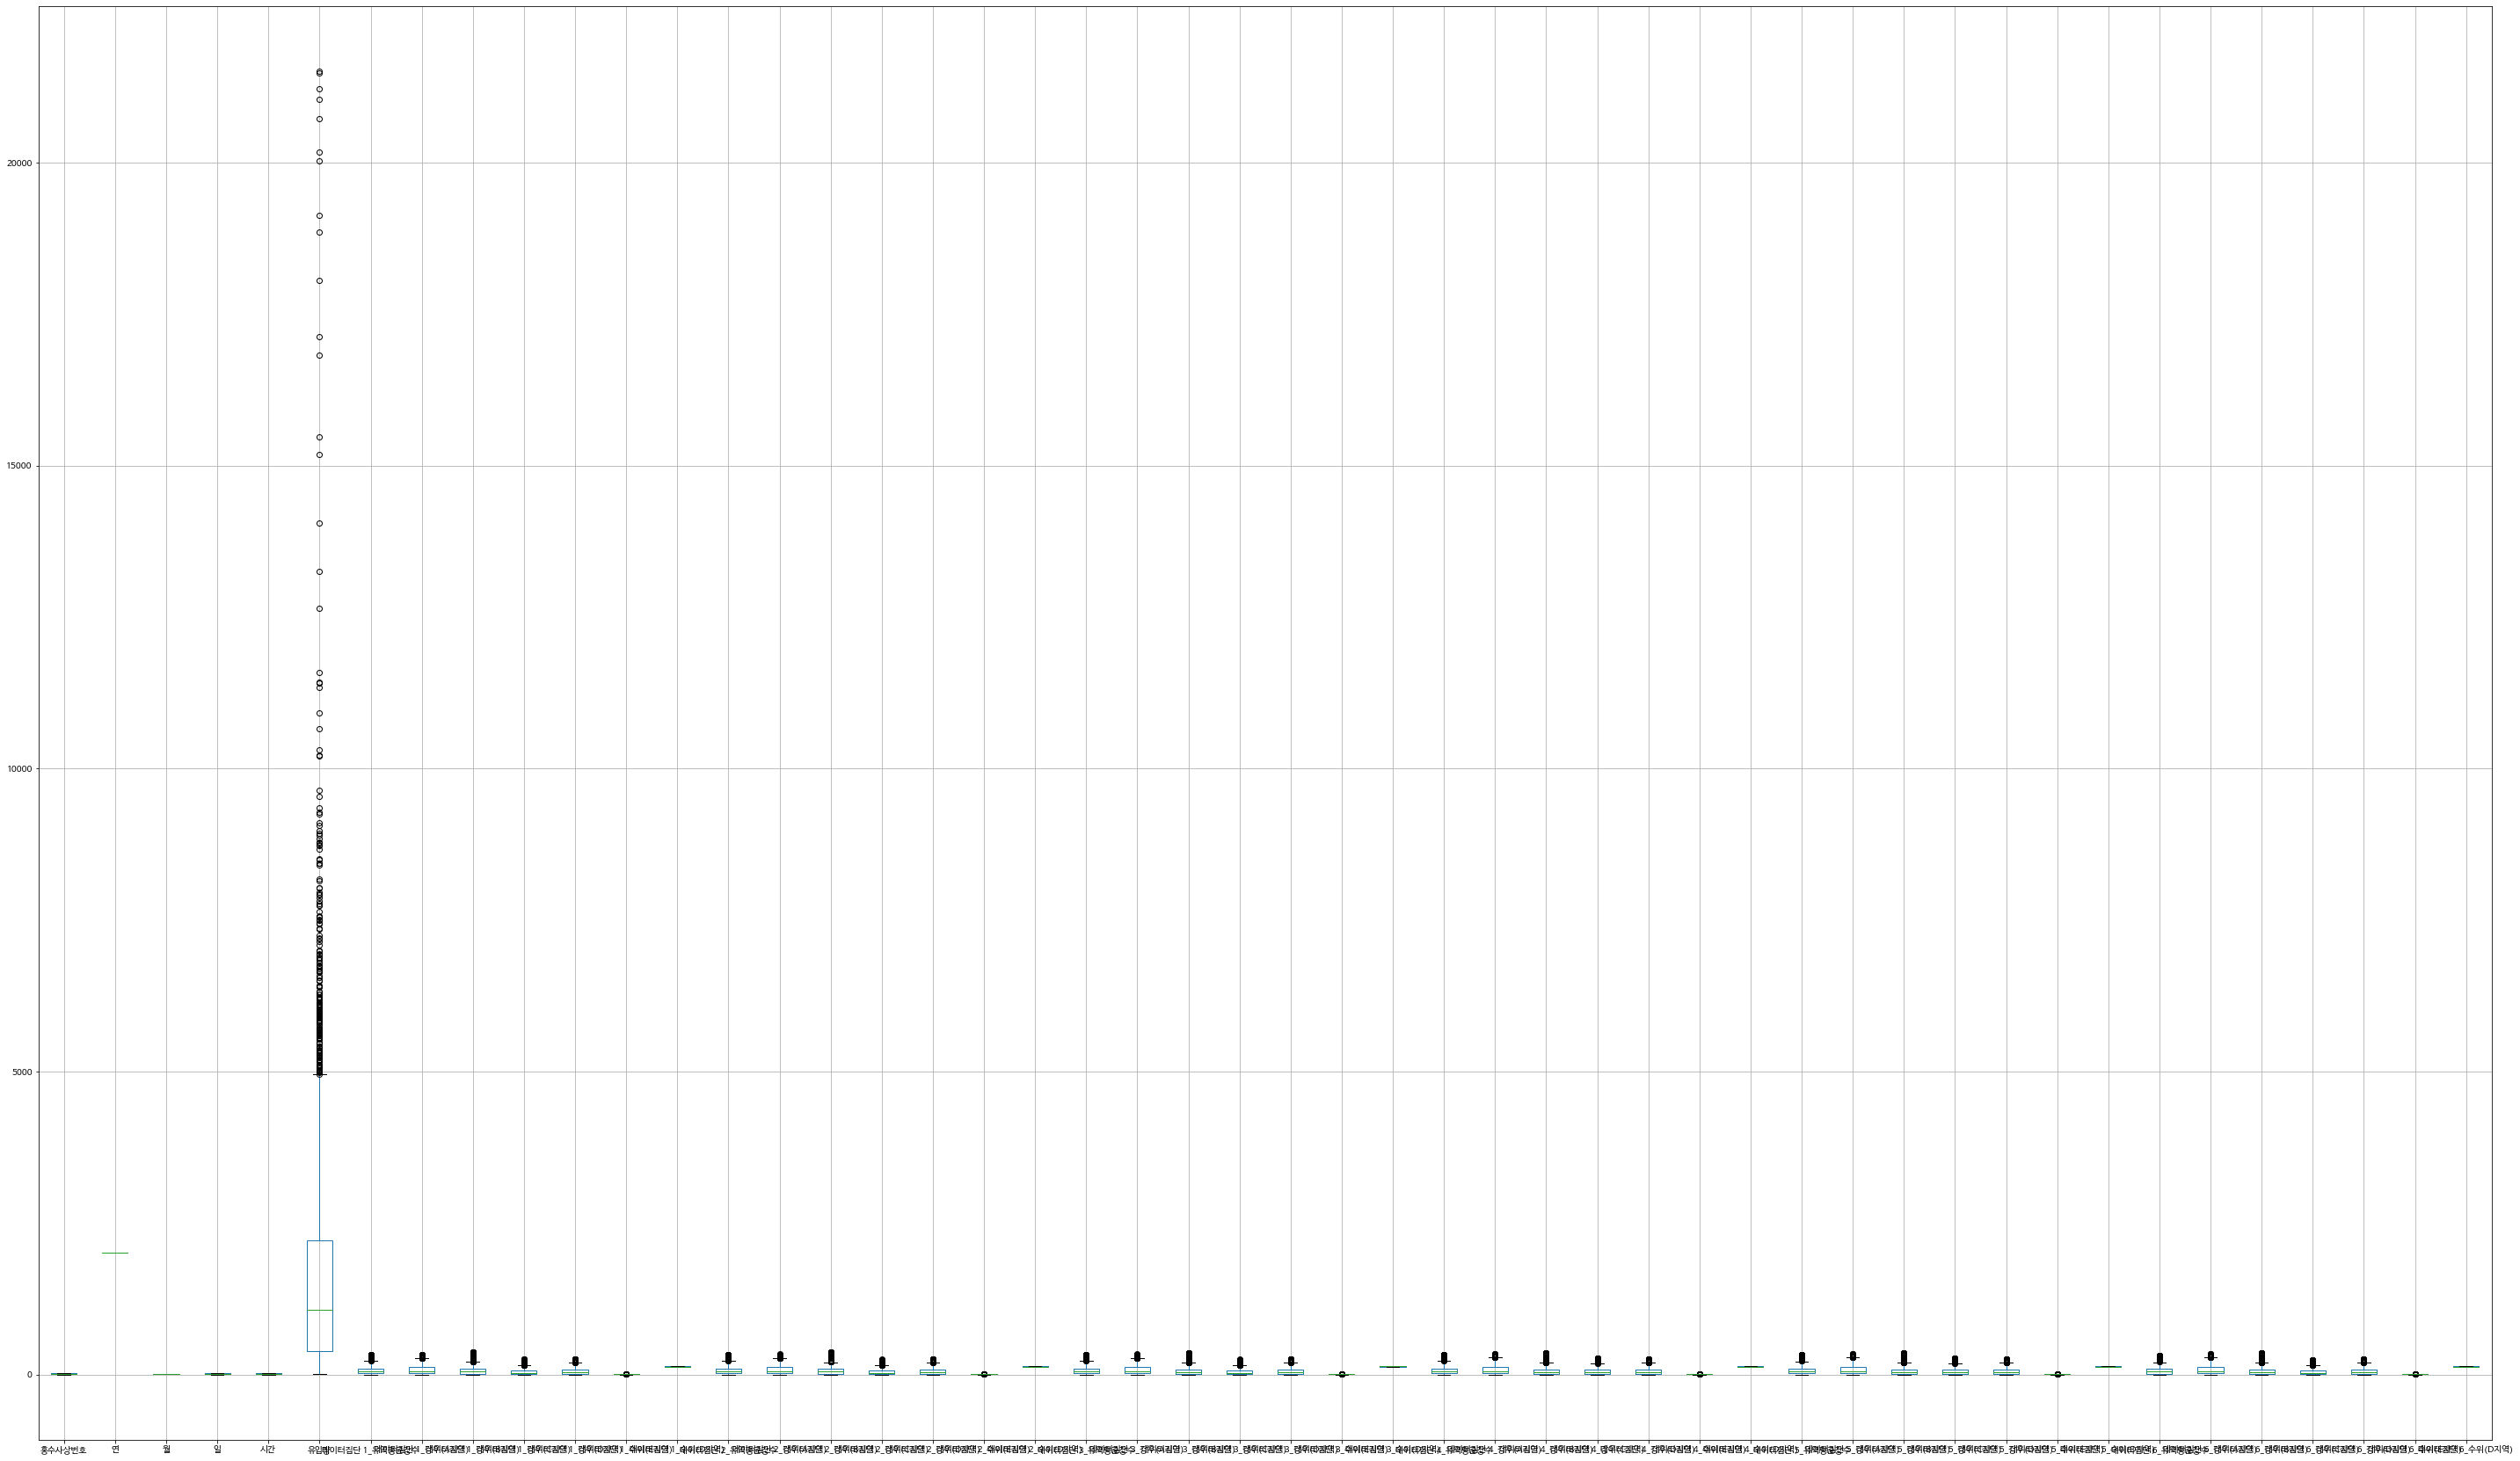

In [8]:
df.boxplot(figsize=(50, 30));

outlier가 존재하는 것을 알 수 있음 -> scaling 필요

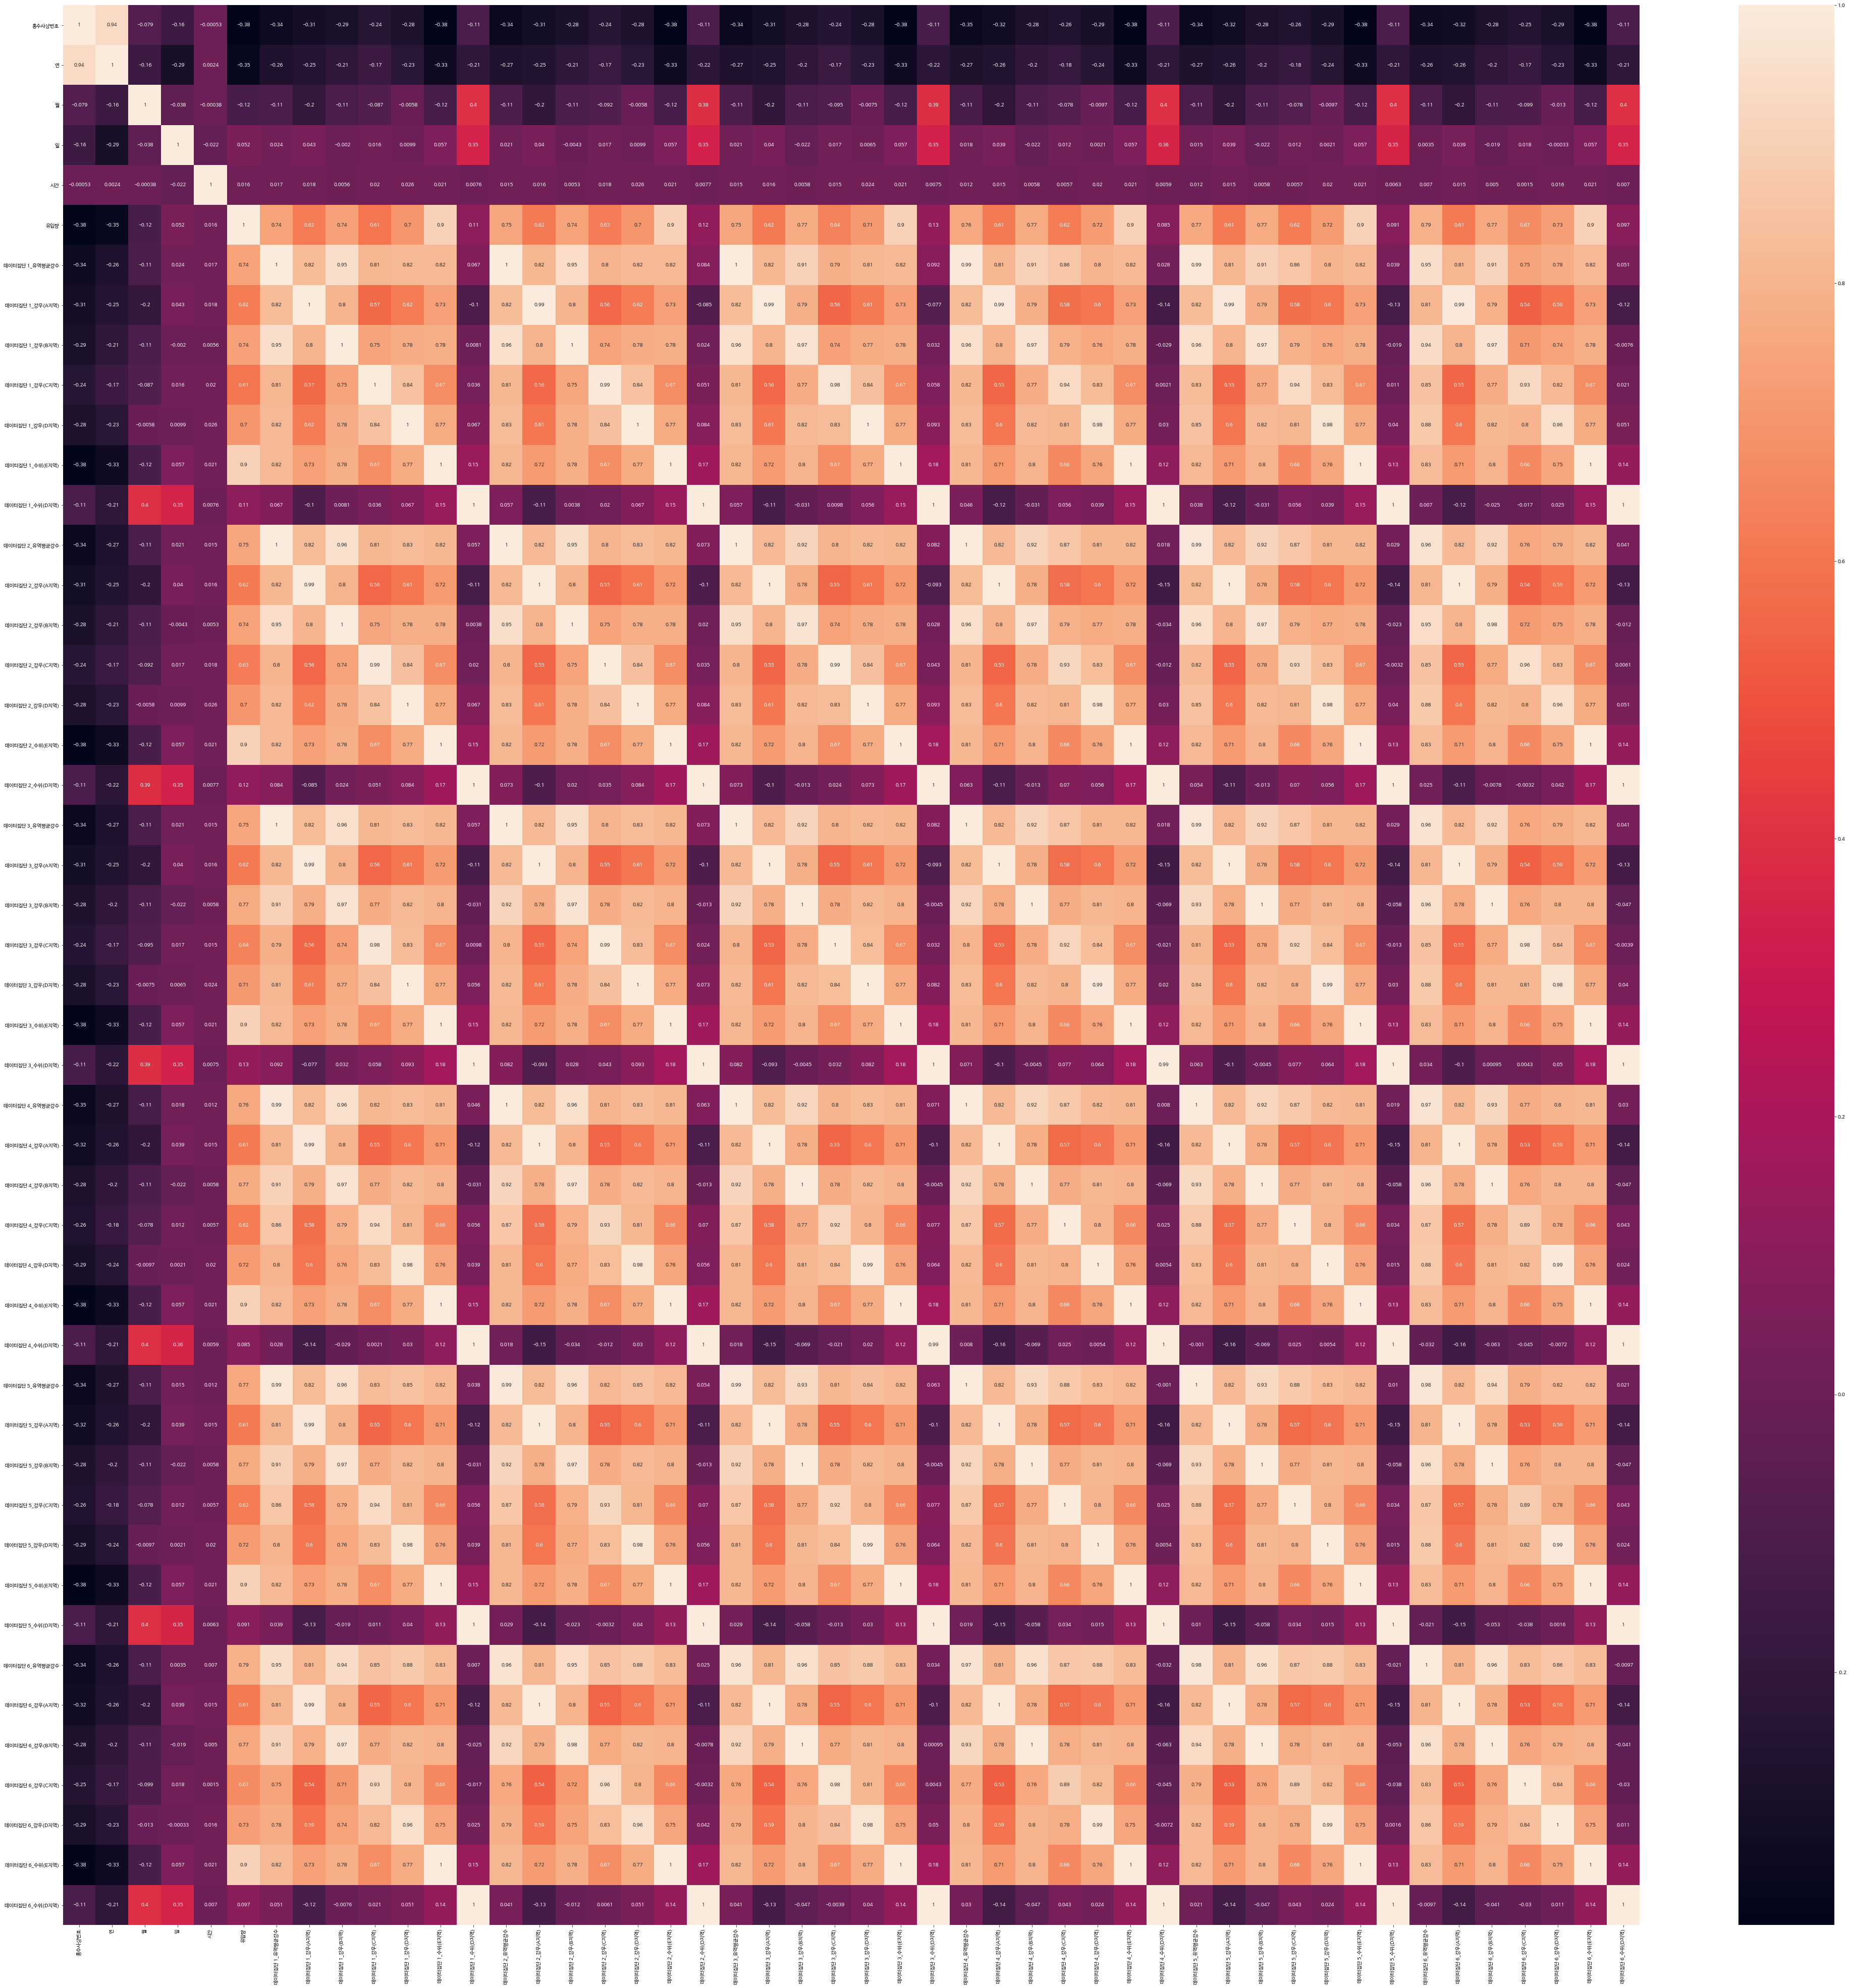

In [9]:
corr_ = df.corr()
plt.figure(figsize=(70, 70))
sns.heatmap(corr_, annot=True)

데이터 집단 간 유사한 상관관계를 보임

In [10]:
# 유역평균강수를 활용하여 E지역의 강우량 산출
for i in range(1, 7):
  df[f'데이터집단 {i}_강우(E지역)'] = df[f'데이터집단 {i}_유역평균강수'] * 5 - (df[f'데이터집단 {i}_강우(A지역)'] + df[f'데이터집단 {i}_강우(B지역)']
                                                  + df[f'데이터집단 {i}_강우(C지역)'] + df[f'데이터집단 {i}_강우(D지역)'])

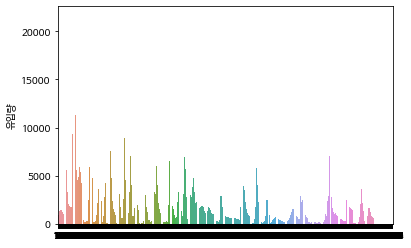

In [12]:
sns.barplot(y=df['유입량'], x=df.index)

In [13]:
# 데이터 집단 합치기
def ave(colname):
  df[colname] = 0
  for i in range(1,7):
    df[colname] += df[f'데이터집단 {i}_' + colname]

  df[colname] = df[colname].apply(lambda _:_/6)

In [14]:
reg = ['A', 'B', 'C', 'D', 'E']
ave('유역평균강수')
for _ in reg:
  ave(f'강우({_}지역)')
  if _ == 'D' or _ == 'E':
    ave(f'수위({_}지역)')

In [15]:
# 사용하기 편하게 column 명 변경
for col in list(filter(lambda _: '(' in _, df.columns)):
  col_tuple = re.findall(r'(.+?)\(([A-E]지역)', col)[0]
  df.rename(columns={col:col_tuple[1]+'_'+col_tuple[0]}, inplace=True)

In [16]:
# 불필요한 열 삭제
df.drop(list(filter(lambda _: '데이터집단' in _, df.columns)), axis=1, inplace=True)

In [17]:
# 강우 -> mm 단위이므로 단위가 m^3/s인 유입량, m인 수위와 단위를 최대한 맞추기 위해서 m로 단위를 바꿈
df[list(filter(lambda _: '강우' in _, df.columns))] = df[list(filter(lambda _: '강우' in _, df.columns))].apply(lambda _:_ * 0.001)

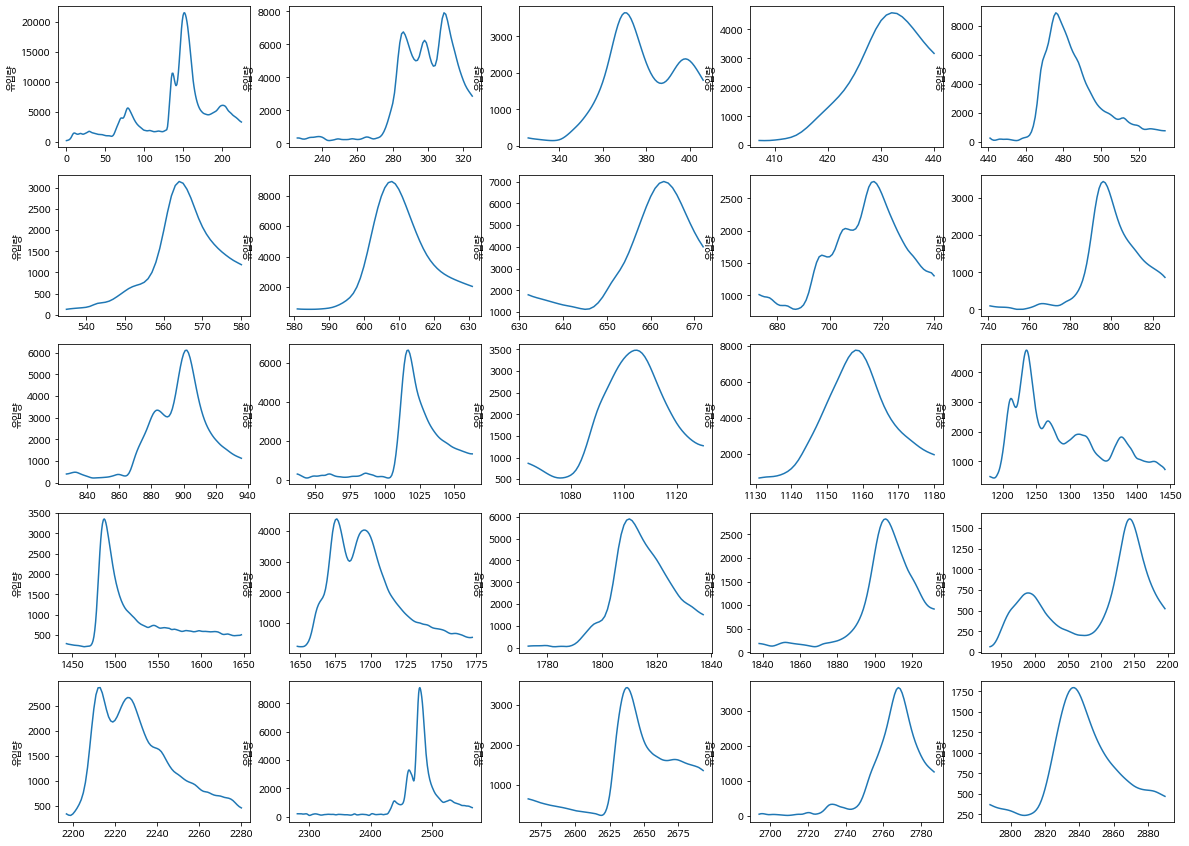

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
for i, ax in zip(range(len(set(df['홍수사상번호'])) - 1), axs.flat):
  sns.lineplot(x=df.loc[df['홍수사상번호']==i+1].index, y=df.loc[df['홍수사상번호']==i+1, '유입량'], ax=ax)

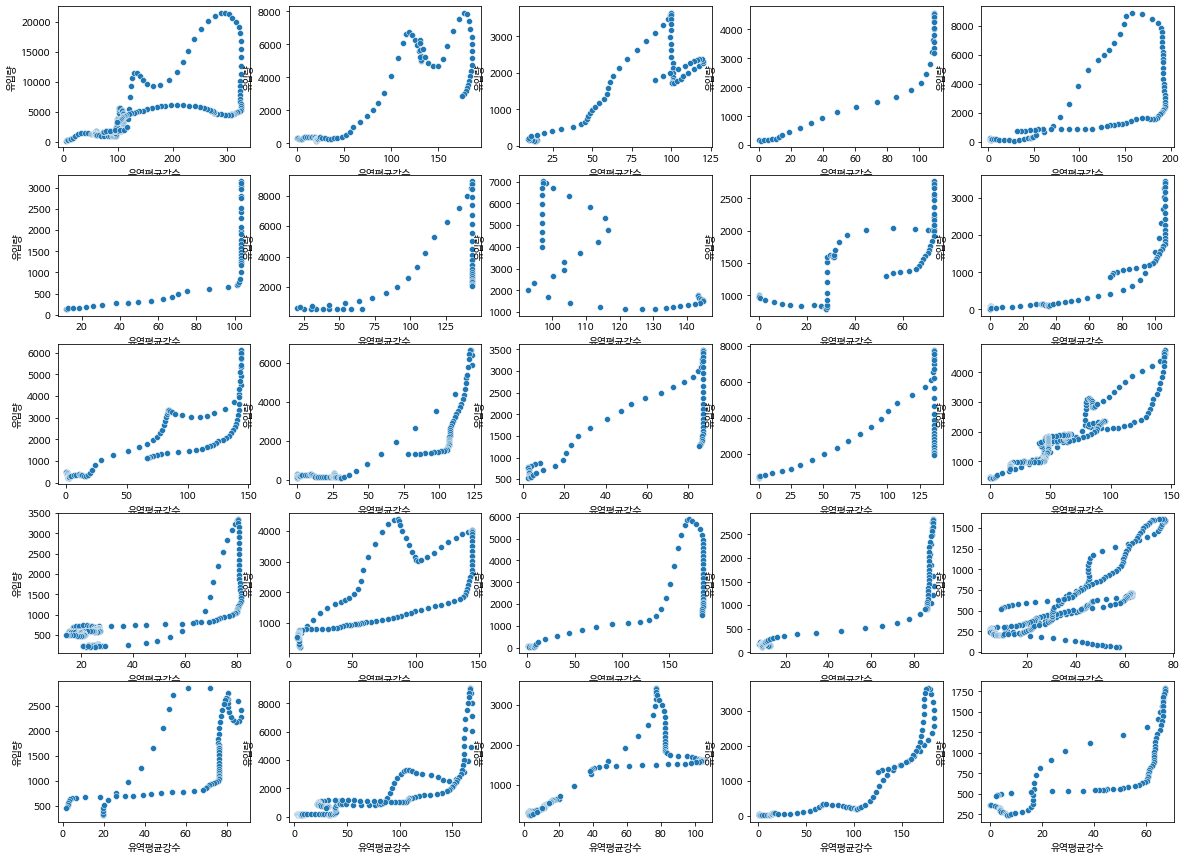

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
for i, ax in zip(range(len(set(df['홍수사상번호'])) - 1), axs.flat):
  sns.scatterplot(x='유역평균강수', y='유입량', data=df.loc[df['홍수사상번호'] == i+1], ax=ax)

In [20]:
df['홍수사상번호'] = df['홍수사상번호'].astype('category')
# 로그 변환
df[df.columns[5:]] = np.log(df[df.columns[5:]] + 1e-5)

In [21]:
diff = [df['D지역_수위'][i] - df['D지역_수위'][i-1] if df['홍수사상번호'][i] == df['홍수사상번호'][i-1] else 0. for i in range(1, len(df))]
diff.insert(0, 0.)
df['D지역_수위 차'] = diff

In [22]:
# E지역 강우가 음수로 계산된 경우 0으로 바꿔주기
df.loc[df['E지역_강우'] < 0, 'E지역_강우'] = 0

In [ ]:
!pip install pycaret

In [24]:
df.drop('유역평균강수', axis=1, inplace=True)

In [25]:
# train, test set으로 나누기
idx = len(df) - len(df.loc[df['유입량'].isna() == True])
train = df.iloc[:idx-1]
# train.drop('홍수사상번호', axis=1, inplace=True)
test = df.iloc[idx:]
# test.drop('홍수사상번호', axis=1, inplace=True)
test.drop('유입량', axis=1, inplace=True)

In [26]:
from pycaret.regression import *

In [39]:
reg1 = setup(data=train, 
             target='유입량', 
             categorical_features=['홍수사상번호'], 
             normalize=True,
             normalize_method='maxabs',
             date_features=['연', '월', '일', '시간'],
             transformation = True,
             silent=True,
             session_id=123)

,Description,Value
0,session_id,123
1,Target,유입량
2,Original Data,"(2890, 14)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2022, 54)"


In [40]:
best_model = compare_models(fold=5, sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0687,0.0201,0.1407,0.9868,0.0202,0.0110,0.966
rf,Random Forest Regressor,0.1046,0.0368,0.1907,0.9758,0.0284,0.0170,1.210
lightgbm,Light Gradient Boosting Machine,0.1177,0.0387,0.1962,0.9746,0.0331,0.0204,0.254
knn,K Neighbors Regressor,0.1213,0.0459,0.2141,0.9700,0.0350,0.0209,0.086
dt,Decision Tree Regressor,0.1241,0.0553,0.2337,0.9634,0.0335,0.0199,0.034
gbr,Gradient Boosting Regressor,0.1672,0.0604,0.2448,0.9602,0.0377,0.0277,0.370
ada,AdaBoost Regressor,0.2828,0.1313,0.3616,0.9137,0.0511,0.0443,0.234
ridge,Ridge Regression,0.2509,0.1376,0.3706,0.9097,0.0595,0.0427,0.020
br,Bayesian Ridge,0.2501,0.1376,0.3706,0.9097,0.0596,0.0426,0.028
lr,Linear Regression,0.2521,0.1376,0.3707,0.9097,0.0595,0.0428,0.020


In [45]:
bagged_models = [ensemble_model(i, optimize='RMSE') for i in best_model]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1200,0.0395,0.1987,0.9749,0.0355,0.0214
1,0.1105,0.0293,0.1713,0.9799,0.0233,0.0171
2,0.1048,0.0297,0.1725,0.9794,0.0259,0.0170
3,0.1176,0.0366,0.1914,0.9767,0.0262,0.0179
4,0.1180,0.0374,0.1934,0.9753,0.0275,0.0188
5,0.1339,0.0558,0.2362,0.9637,0.0393,0.0244
6,0.1237,0.0471,0.2169,0.9707,0.0437,0.0245
7,0.1178,0.0369,0.1922,0.9706,0.0274,0.0188
8,0.1011,0.0302,0.1739,0.9828,0.0318,0.0185
9,0.1112,0.0372,0.1930,0.9758,0.0417,0.0224


In [49]:
best = automl(optimize='RMSE')

In [50]:
final = finalize_model(best)

In [51]:
pred = predict_model(final, test)

In [53]:
# 로그 변환한 데이터 다시 원래대로 돌려놓기
pred[pred.columns[5:]] = np.exp(pred[pred.columns[5:]])

In [82]:
y = np.array(pred['Label'])

In [58]:
submission = pd.read_excel(dirpath+'submission.xlsx')
submission.head()

,NO,홍수사상번호,연,월,일,시간,유입량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,26.0,2018.0,7.0,1.0,6.0,NaN
2,2.0,26.0,2018.0,7.0,1.0,7.0,NaN
3,3.0,26.0,2018.0,7.0,1.0,8.0,NaN
4,4.0,26.0,2018.0,7.0,1.0,9.0,NaN


In [59]:
submission.drop(0, axis=0, inplace=True)

In [84]:
submission['유입량'] = y

In [86]:
submission.to_excel(dirpath+'final_submission.xlsx')